In [641]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from langdetect import detect
import langdetect
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import FunctionTransformer
import en_core_web_lg
from tqdm import tqdm_pandas, tqdm_notebook
import tokenize_uk

pd.set_option('display.max_colwidth', 100)

In [169]:
tqdm_notebook().pandas()

In [137]:
nlp = en_core_web_lg.load()

In [313]:
df = pd.read_csv('scraper/data-phones.csv')
df['review'] = df['review'].apply(json.loads)
#df['scores'] = df['scores'].apply(json.loads)
print("Rows: ", len(df))
df.head()

Rows:  49890


,review,id,scores
0,{'_': 'Пришел не рабочий телефон. Самостоятельно выключается. При включении на экране белая поло...,18896982,NaN
1,{'_': 'Не розумію..... це підробка??? Адже якщо мені не зраджує пам*ять iPhone6 випускався лише ...,18840918,NaN
2,"{'_': 'Чудовий телефон , приємні знижки та якісне обслуговування', 'Переваги:': 'Легкий,швидкий,...",18780426,5.0
3,{'_': 'Он полностю новий?'},18736812,5.0
4,"{'_': 'Телефон и правда ещё очень актуальный сам пользуюсь и рад производительности,второй 5s та...",18534645,4.0


For now just stick with main part of review

In [314]:
df['main_review'] = df['review'].apply(lambda x: x['_'])
df.head()

,review,id,scores,main_review
0,{'_': 'Пришел не рабочий телефон. Самостоятельно выключается. При включении на экране белая поло...,18896982,NaN,Пришел не рабочий телефон. Самостоятельно выключается. При включении на экране белая полоска и з...
1,{'_': 'Не розумію..... це підробка??? Адже якщо мені не зраджує пам*ять iPhone6 випускався лише ...,18840918,NaN,Не розумію..... це підробка??? Адже якщо мені не зраджує пам*ять iPhone6 випускався лише в трьох...
2,"{'_': 'Чудовий телефон , приємні знижки та якісне обслуговування', 'Переваги:': 'Легкий,швидкий,...",18780426,5.0,"Чудовий телефон , приємні знижки та якісне обслуговування"
3,{'_': 'Он полностю новий?'},18736812,5.0,Он полностю новий?
4,"{'_': 'Телефон и правда ещё очень актуальный сам пользуюсь и рад производительности,второй 5s та...",18534645,4.0,"Телефон и правда ещё очень актуальный сам пользуюсь и рад производительности,второй 5s так же пр..."


Filter those written in ukrainian

In [315]:
def detect_lang(x):
    try:
        return detect(x)
    except langdetect.lang_detect_exception.LangDetectException:
        pass
        
df_uk = df[df['main_review'].progress_apply(detect_lang) == 'uk'].copy()
print("Rows: ", len(df_uk))
df_uk.head()


Rows:  10231


,review,id,scores,main_review
0,{'_': 'Пришел не рабочий телефон. Самостоятельно выключается. При включении на экране белая поло...,18896982,NaN,Пришел не рабочий телефон. Самостоятельно выключается. При включении на экране белая полоска и з...
1,{'_': 'Не розумію..... це підробка??? Адже якщо мені не зраджує пам*ять iPhone6 випускався лише ...,18840918,NaN,Не розумію..... це підробка??? Адже якщо мені не зраджує пам*ять iPhone6 випускався лише в трьох...
2,"{'_': 'Чудовий телефон , приємні знижки та якісне обслуговування', 'Переваги:': 'Легкий,швидкий,...",18780426,5.0,"Чудовий телефон , приємні знижки та якісне обслуговування"
3,{'_': 'Он полностю новий?'},18736812,5.0,Он полностю новий?
4,"{'_': 'Телефон и правда ещё очень актуальный сам пользуюсь и рад производительности,второй 5s та...",18534645,4.0,"Телефон и правда ещё очень актуальный сам пользуюсь и рад производительности,второй 5s так же пр..."


Leave only those with scores

In [318]:
main_key = 'Общее впечатление'
taste_key = 'Соответствие вкуса'
aroma_key = 'Соответствие аромата'
def combine_scores(scores):
    if main_key in scores:
        main = scores.get(main_key)
        taste = scores.get(taste_key)
        aroma = scores.get(aroma_key)
        raws = list(filter(lambda x: x, [main, taste, aroma]))
        return np.mean(raws)
df_uk = df_uk.assign(score_raw=df_uk['scores'])
df_ws = df_uk[pd.notna(df_uk['score_raw'])].copy()
print("Rows: ", len(df_ws))
df_ws.head()

Rows:  4317


,review,id,scores,main_review,score_raw
2,"{'_': 'Чудовий телефон , приємні знижки та якісне обслуговування', 'Переваги:': 'Легкий,швидкий,...",18780426,5.0,"Чудовий телефон , приємні знижки та якісне обслуговування",5.0
12,{'_': 'Запитання: чи є в ньому функцію запису телефонної розмови?'},19373305,4.0,Запитання: чи є в ньому функцію запису телефонної розмови?,4.0
15,{'_': 'Користуюсь два тижні. Достойний телефон. Працює швидкоі і злагоджено. Дуже зручно зі скан...,21074865,5.0,"Користуюсь два тижні. Достойний телефон. Працює швидкоі і злагоджено. Дуже зручно зі сканером, х...",5.0
22,"{'_': 'Підскажи який стоїть Андроїд? І чи є до нього захисне скло і чохол?', 'Недоліки:': '-'}",20476907,5.0,Підскажи який стоїть Андроїд? І чи є до нього захисне скло і чохол?,5.0
60,"{'_': 'Користуюсь вже два місяці, телефон крутий, тільки одна порада не купляйте джет блек, а пр...",16161182,5.0,"Користуюсь вже два місяці, телефон крутий, тільки одна порада не купляйте джет блек, а простий ч...",5.0


In [340]:
1+4/3,1+4/3+4/3,1+4/3+4/3+4/3

(2.333333333333333, 3.666666666666666, 4.999999999999999)

Digitize scores

In [349]:
def digitize(n):
    if (1 <= n) and (n < 3):
        return 0
    elif (3 <= n) and (n < 4):
        return 1
    elif (4 <= n) and (n <= 5):
        return 2
    else:
        return None
bins = 1+np.array([4/3,2*4/3])
df_ws['score'] = np.digitize(df_ws['score_raw'], bins)
df_ws.head()

,review,id,scores,main_review,score_raw,score
2,"{'_': 'Чудовий телефон , приємні знижки та якісне обслуговування', 'Переваги:': 'Легкий,швидкий,...",18780426,5.0,"Чудовий телефон , приємні знижки та якісне обслуговування",5.0,2
12,{'_': 'Запитання: чи є в ньому функцію запису телефонної розмови?'},19373305,4.0,Запитання: чи є в ньому функцію запису телефонної розмови?,4.0,2
15,{'_': 'Користуюсь два тижні. Достойний телефон. Працює швидкоі і злагоджено. Дуже зручно зі скан...,21074865,5.0,"Користуюсь два тижні. Достойний телефон. Працює швидкоі і злагоджено. Дуже зручно зі сканером, х...",5.0,2
22,"{'_': 'Підскажи який стоїть Андроїд? І чи є до нього захисне скло і чохол?', 'Недоліки:': '-'}",20476907,5.0,Підскажи який стоїть Андроїд? І чи є до нього захисне скло і чохол?,5.0,2
60,"{'_': 'Користуюсь вже два місяці, телефон крутий, тільки одна порада не купляйте джет блек, а пр...",16161182,5.0,"Користуюсь вже два місяці, телефон крутий, тільки одна порада не купляйте джет блек, а простий ч...",5.0,2


In [350]:
train,test = train_test_split(df_ws, test_size=0.3)
train.to_csv('train.phones.csv', index=False)
test.to_csv('test.phones.csv', index=False)
train = pd.read_csv('train.phones.csv')
test = pd.read_csv('test.phones.csv')

Load ukranian stemmer (borrowed from https://github.com/Amice13/ukr_stemmer)

In [294]:
%run -n ukr_stemmer3.py

In [477]:
def stem(xs):
    return np.array([UkrainianStemmer(x).stem_word() for x in xs])

def stem_all(X):
    stem_vec = np.vectorize(stem)
    return stem_vec(X)

In [478]:
def tokenize(x, lowercase=False):
    tokens = tokenize_uk.tokenize_words(x)
    if lowercase==True:
        return [tok.lower() for tok in tokens]
    else:
        return tokens

In [479]:
train = train.assign(review_doc = train['main_review'].apply(lambda x: tokenize(x, lowercase=True)))
test = test.assign(review_doc = test['main_review'].apply(lambda x: tokenize(x, lowercase=True)))

In [624]:
vocab = CountVectorizer(tokenizer=lambda x: stem(x), lowercase=False).fit(train['review_doc'], train['score']).vocabulary_
idxs, ivocab = zip(*sorted(zip(vocab.values(),vocab.keys())))
ivocab = np.array(ivocab)

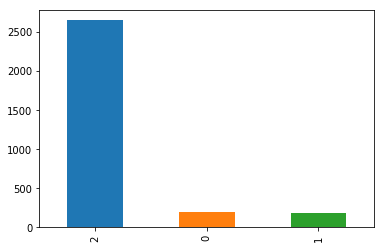

In [394]:
train['score'].value_counts().plot(kind='bar')

In [524]:
print("Baseline score:", accuracy_score(test['score'], np.full(test['score'].shape, 2)))

Baseline score: 0.8680555555555556


In [666]:
def print_metrics(cls, train, test):   
    print("Train score: ", cls.score(train['review_doc'], train['score']))
    print("Test score: ", cls.score(test['review_doc'], test['score']))
    pred = cls.predict(test['review_doc'])
    print("Test precision: ", precision_score(test['score'], pred, average=None))
    print("Test recall:", recall_score(test['score'], pred, average=None))
    print("F1:", f1_score(test['score'],pred, average=None))
    print("F1-macro:", f1_score(test['score'],pred,average='macro'))
    return confusion_matrix(test['score'], pred)

### Classification v1 (Naive Bayes)

In [667]:
p1 = Pipeline([('vectorizer', CountVectorizer(lowercase=False, tokenizer=lambda x: stem(x), vocabulary=vocab)),
               ('classifier', MultinomialNB())])
p1.fit(train['review_doc'], train['score'])
print_metrics(p1, train, test)

Train score:  0.9139357828533599
Test score:  0.8680555555555556
Test precision:  [0.25       0.         0.86996904]
Test recall: [0.01086957 0.         0.99911111]
F1: [0.02083333 0.         0.93007861]
F1-macro: 0.3169706477267504


/Users/serhiinechyporhuk/.local/share/virtualenvs/SerhiiNechyporchuk-Ib9yWLjX/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/serhiinechyporhuk/.local/share/virtualenvs/SerhiiNechyporchuk-Ib9yWLjX/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[   1,    0,   91],
       [   2,    0,   77],
       [   1,    0, 1124]])

In [668]:
nb_p = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: stem(x), vocabulary=vocab)),
               ('classifier', MultinomialNB())])
nb_p.fit(train['review_doc'], train['score'])
print_metrics(nb_p, train, test)

Train score:  0.874875868917577
Test score:  0.8680555555555556
Test precision:  [0.         0.         0.86805556]
Test recall: [0. 0. 1.]
F1: [0.         0.         0.92936803]
F1-macro: 0.3097893432465923


/Users/serhiinechyporhuk/.local/share/virtualenvs/SerhiiNechyporchuk-Ib9yWLjX/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/serhiinechyporhuk/.local/share/virtualenvs/SerhiiNechyporchuk-Ib9yWLjX/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[   0,    0,   92],
       [   0,    0,   79],
       [   0,    0, 1125]])

### Classification v1 (Logistic Regression)

In [669]:
from sklearn.linear_model import LogisticRegression

lr_p = Pipeline([('vectorizer', CountVectorizer(lowercase=False, tokenizer=lambda x: stem(x), vocabulary=vocab)),
                 ('classifier', LogisticRegression())])
lr_p.fit(train['review_doc'], train['score'])
print_metrics(lr_p, train, test)

Train score:  0.9778219132737505
Test score:  0.8734567901234568
Test precision:  [0.5        0.26315789 0.89812551]
Test recall: [0.27173913 0.06329114 0.97955556]
F1: [0.35211268 0.10204082 0.93707483]
F1-macro: 0.46374277410494713


array([[  25,    3,   64],
       [  13,    5,   61],
       [  12,   11, 1102]])

## with tonal dictionary

loading tonal dict

In [398]:
tonal_dict = {}
with open('tone-dict-uk.tsv') as f:
    for line in f.readlines():
        word, ts = line.strip().split('\t')
        tonal_dict[UkrainianStemmer(word.lower()).stem_word()] = int(ts)

In [616]:
class TonalClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, vocab, tonal_dict):
        self.vocab = vocab
        self.tonal_dict = tonal_dict
        self.ivocab = np.zeros((len(vocab),))
        for w,i in vocab.items():
            self.ivocab[i] = tonal_dict.get(w, np.nan)
            
    def get_params(self, deep):
        return {'vocab': vocab, 'tonal_dict': tonal_dict}
    
    def set_params(self, **params):
        self.vocab = params['vocab']
        self.tonal_dict = params['tonal_dict']
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        res = np.zeros((X.shape[0],))
        for i in range(res.shape[0]):
            Xi = X[i, :]
            scores = self.ivocab[Xi.nonzero()[1]]
            if all(np.isnan(scores)):
                res[i] = 0
            else:
                res[i] = np.nanmean(scores)
        return np.digitize(res, [-2+4/3,-2+2*4/3])
    
    def score(self, X, y):
        pred = self.predict(X)
        matches = pred == y
        return np.sum(matches)/len(pred)

In [670]:
tonal_p = Pipeline([('vectorizer', CountVectorizer(lowercase=False, tokenizer=lambda x: stem(x), vocabulary=vocab)),
              ('classifier', TonalClassifier(vocab, tonal_dict))])
tonal_p.fit(train['review_doc'], train['score'])
print_metrics(tonal_p, train, test)

Train score:  0.4468718967229394
Test score:  0.44521604938271603
Test precision:  [0.23478261 0.074883   0.92962963]
Test recall: [0.29347826 0.60759494 0.44622222]
F1: [0.26086957 0.13333333 0.603003  ]
F1-macro: 0.3324019671845759


array([[ 27,  47,  18],
       [ 11,  48,  20],
       [ 77, 546, 502]])

We see that classifier that uses only tonal date is pretty low behind the baseline. Let's try an ensemble of this two classifiers

### Ensemble

In [671]:
from sklearn.ensemble import VotingClassifier

vcl = VotingClassifier([('nb', nb_p),('tonal', tonal_p), ('lr', lr_p)], weights=[2, 4, 7])
vcl.fit(train['review_doc'], train['score'])
print_metrics(vcl, train, test)

Train score:  0.9778219132737505
Test score:  0.8734567901234568
Test precision:  [0.5        0.26315789 0.89812551]
Test recall: [0.27173913 0.06329114 0.97955556]
F1: [0.35211268 0.10204082 0.93707483]
F1-macro: 0.46374277410494713


array([[  25,    3,   64],
       [  13,    5,   61],
       [  12,   11, 1102]])

### Sidenote 1
We see that it's really hard to beat the baseline with such skewed dataset, so let's upsample it

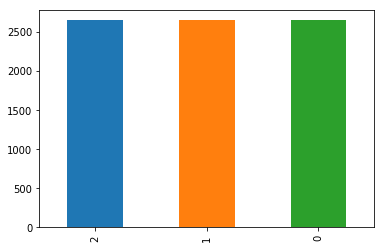

In [627]:
train2 = train.copy()
max_count = np.max(train2['score'].value_counts())
addition = []
for cat in range(3):
    train2_cat = train2[train2['score'] == cat]
    diff = max_count - len(train2_cat)
    addition.append(train2_cat.sample(n=diff, replace=True))
train2 = train2.append(addition, ignore_index=True).reset_index()
train2['score'].value_counts().plot('bar')

Try again Naive Bayes

In [672]:
nb_p = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False, tokenizer=lambda x: stem(x), vocabulary=vocab)),
               ('classifier', MultinomialNB())])
nb_p.fit(train2['review_doc'], train2['score'])
print_metrics(nb_p, train, test)

Train score:  0.9069844422376696
Test score:  0.7608024691358025
Test precision:  [0.37857143 0.12121212 0.94885177]
Test recall: [0.57608696 0.30379747 0.808     ]
F1: [0.45689655 0.1732852  0.87277964]
F1-macro: 0.5009871316744179


array([[ 53,  21,  18],
       [ 24,  24,  31],
       [ 63, 153, 909]])

Try again logistic regression

In [673]:
lr_p = Pipeline([('vectorizer', CountVectorizer(lowercase=False, tokenizer=lambda x: stem(x), vocabulary=vocab)),
                 ('classifier', LogisticRegression())])
lr_p.fit(train2['review_doc'], train2['score'])
print_metrics(lr_p, train, test)

Train score:  0.9940417080436942
Test score:  0.8395061728395061
Test precision:  [0.35643564 0.171875   0.9204244 ]
Test recall: [0.39130435 0.13924051 0.92533333]
F1: [0.37305699 0.15384615 0.92287234]
F1-macro: 0.48325849636344625


array([[  36,    9,   47],
       [  25,   11,   43],
       [  40,   44, 1041]])

We see nice improvement 